# **Drug Sales Analysis**
### Author: Dragon Xu (runshenx)
### Date: 09/16/2024

In [ ]:
# Import all the necessary packages
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics
from random import gauss #create gaussian white noise
from random import seed
from pandas import Series
from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity
from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA
!pip install pmdarima #for auto arima
import pmdarima as pm #auto arima
from google.colab import drive
import altair as alt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [ ]:
# Set up colab access to personal google drive
drive.mount('/content/drive')
# Initialize all the constants
file_path = '/content/drive/MyDrive/Colab Notebooks/95835 Time Series Forecasting/drug_sales_australia.csv'
col_value = 'value'
col_date = 'date'
test_size = 12
# Define backtest periods
backtest_periods = [
    (datetime(2004, 7, 1), datetime(2005, 6, 30)),
    (datetime(2005, 7, 1), datetime(2006, 6, 30)),
    (datetime(2006, 7, 1), datetime(2007, 6, 30)),
    (datetime(2007, 7, 1), datetime(2008, 6, 30))
]
# Define model name
model_names = ['Single ETS 1', 'Single ETS 2', 'Single ETS 3', 'Double ETS 1', 'Double ETS 2', 'Triple ETS 1', 'Triple ETS 2', 'ARIMA Manual', 'Auto ARIMA NonSeasonal', 'Auto ARIMA Seasonal']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read in anti-diabetic drug sales data
df_sales = pd.read_csv(file_path, parse_dates=[col_date], index_col=[col_date])
# Explicitly convert index to DatetimeIndex and set the frequency
if not isinstance(df_sales.index, pd.DatetimeIndex):
    df_sales.index = pd.to_datetime(df_sales.index)
df_sales.index = pd.DatetimeIndex(df_sales.index, freq='MS')

In [ ]:
# Print the dataframe for inspection
print(df_sales)
# Check for missing index in case we need to fill those values
print(pd.date_range(start = df_sales.index.min(), end = df_sales.index.max(), freq='MS').difference(df_sales.index))
# Check for null values
print(df_sales.isnull().sum())
print(df_sales.index.freq)

                value
date                 
1991-07-01   3.526591
1991-08-01   3.180891
1991-09-01   3.252221
1991-10-01   3.611003
1991-11-01   3.565869
...               ...
2008-02-01  21.654285
2008-03-01  18.264945
2008-04-01  23.107677
2008-05-01  22.912510
2008-06-01  19.431740

[204 rows x 1 columns]
DatetimeIndex([], dtype='datetime64[ns]', freq='MS')
value    0
dtype: int64
<MonthBegin>


# Part 1: ETS Models

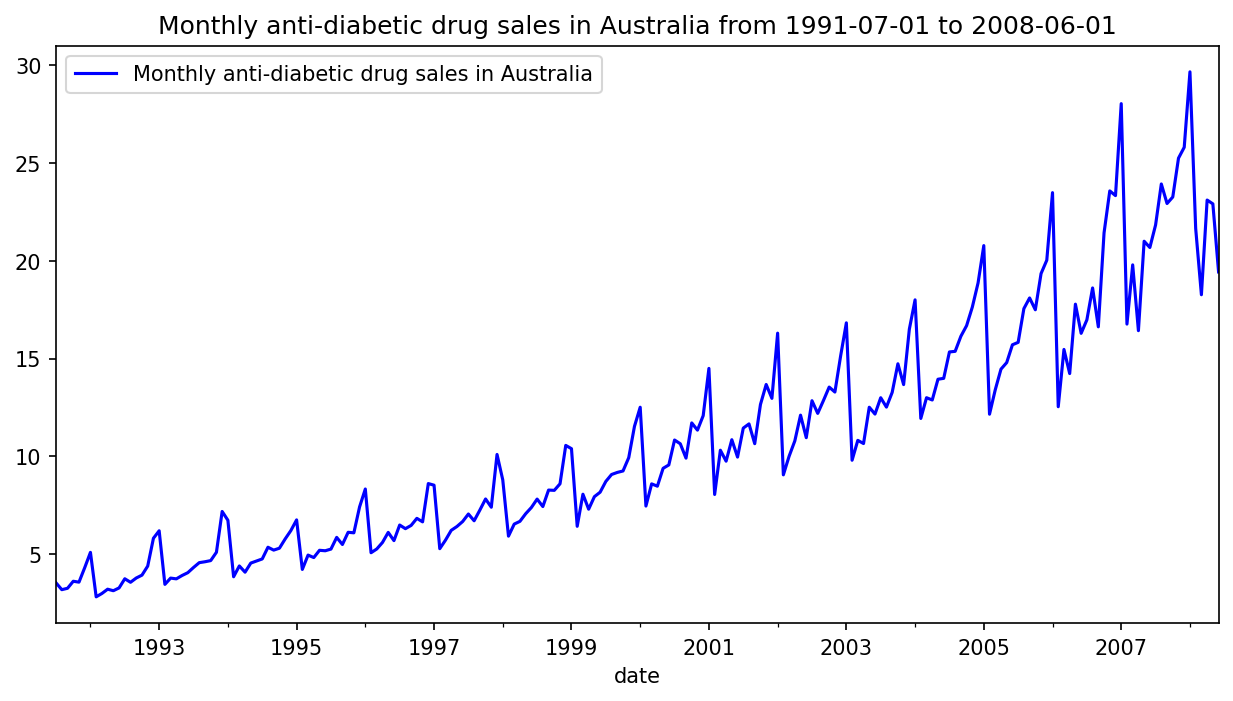

In [ ]:
def plot_line_data(df, y, x):
  # Set the plot size
  plt.figure(figsize=(10, 5), dpi=150) #dpi = resolution. default 100.
  # in plot method we set the label and color of the curve.
  df[y].plot(label='Monthly anti-diabetic drug sales in Australia', color='blue')
  # adding title to the plot
  plt.title('Monthly anti-diabetic drug sales in Australia from {} to {}'.format('1991-07-01', '2008-06-01'))
  # adding Label to the x-axis
  plt.xlabel(x)
  # adding legend to the curve
  plt.legend()

# Visualizing the series
plot_line_data(df_sales, col_value, col_date)

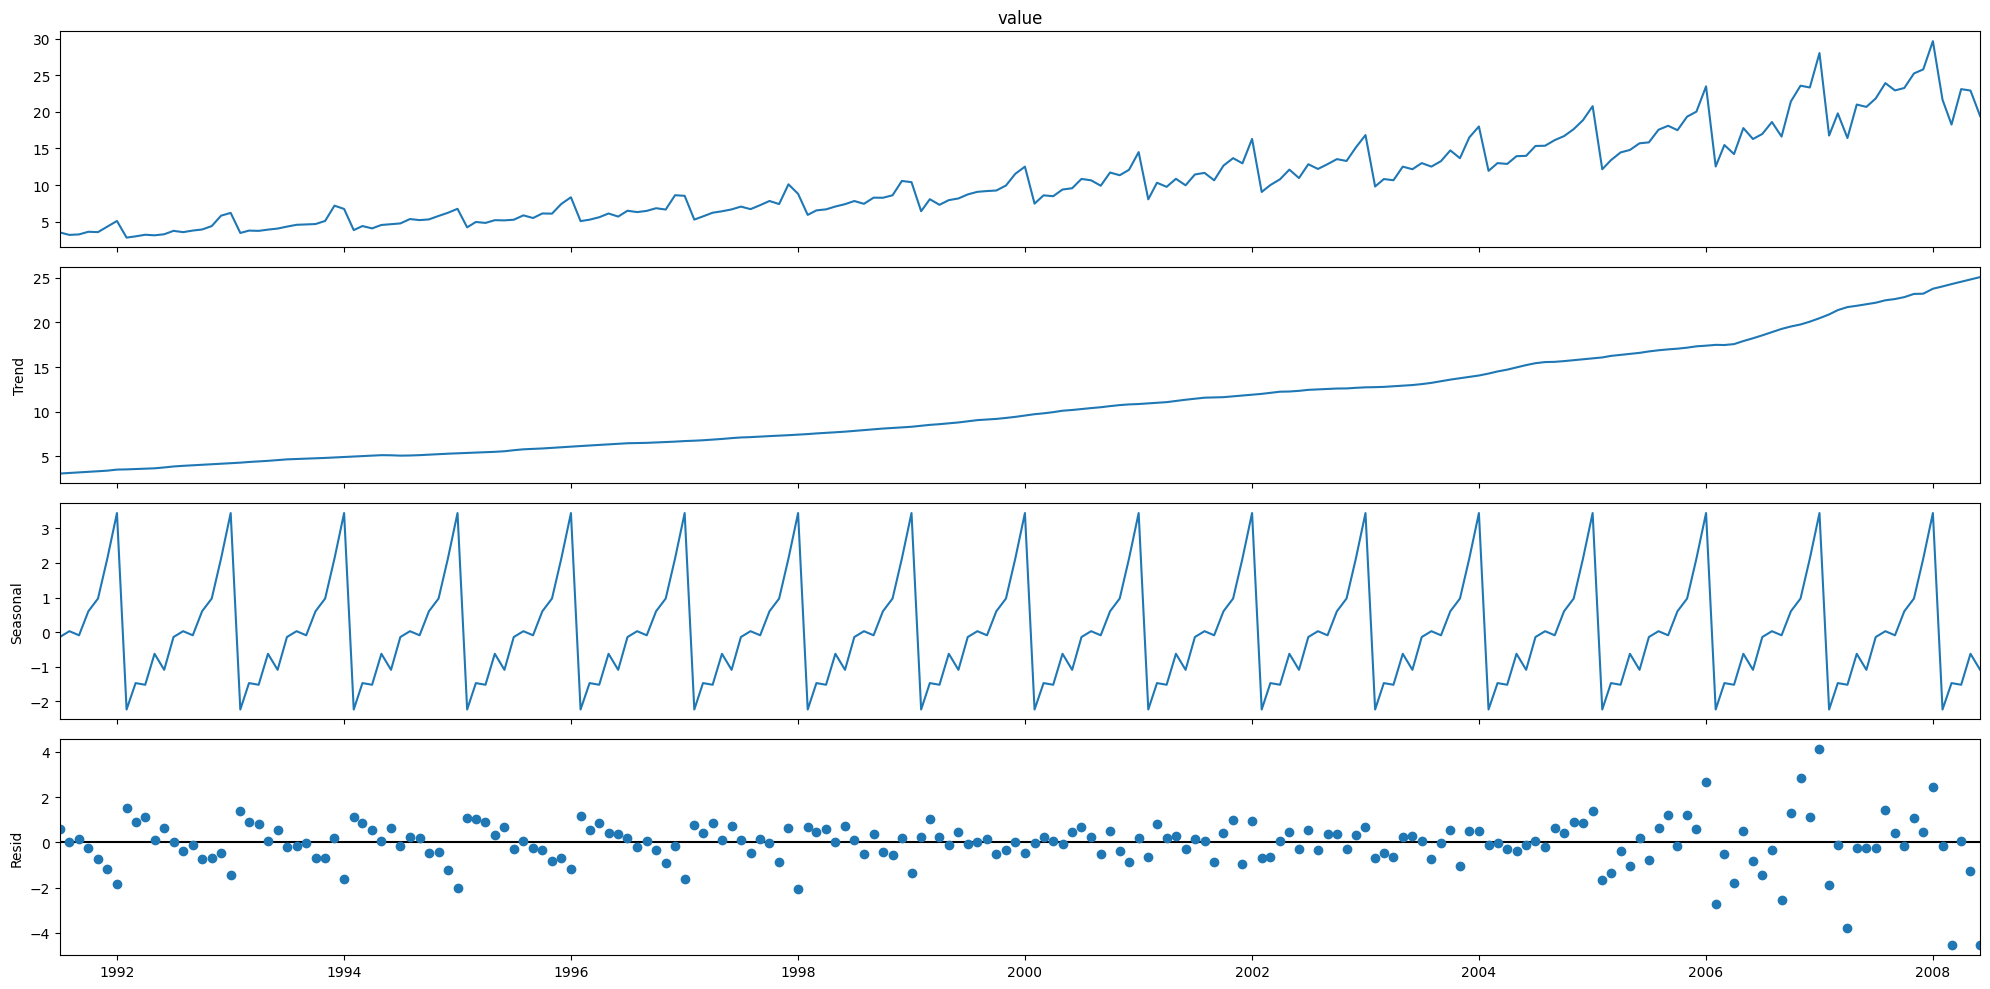

In [ ]:
def plot_decomposition(df, y):
  # Plot time series decomposition to see trend, sesonality, and residual
  res = sm.tsa.seasonal_decompose(df[y], period=12, extrapolate_trend='freq')
  fig = res.plot()
  fig.set_size_inches((20, 10))
  # Tight layout to realign things
  fig.tight_layout()
  plt.show()
# Plot decomposition of the time series data
plot_decomposition(df_sales, col_value)

1. By doing some inspection on the time series data, we find no missing index or null values, which means we don't need data cleaning for now.

1. After plotting the data we can see that it has an additive trend and multiplicative seasonality, which informs how we should construct ETS and ARIMA models.

3. The decomposition plot tells us similar information about trend and seasonality as the line plot above, and it also shows some seasonality in the residuals, meaning that there is some information left to be extracted by trend and seasonality.

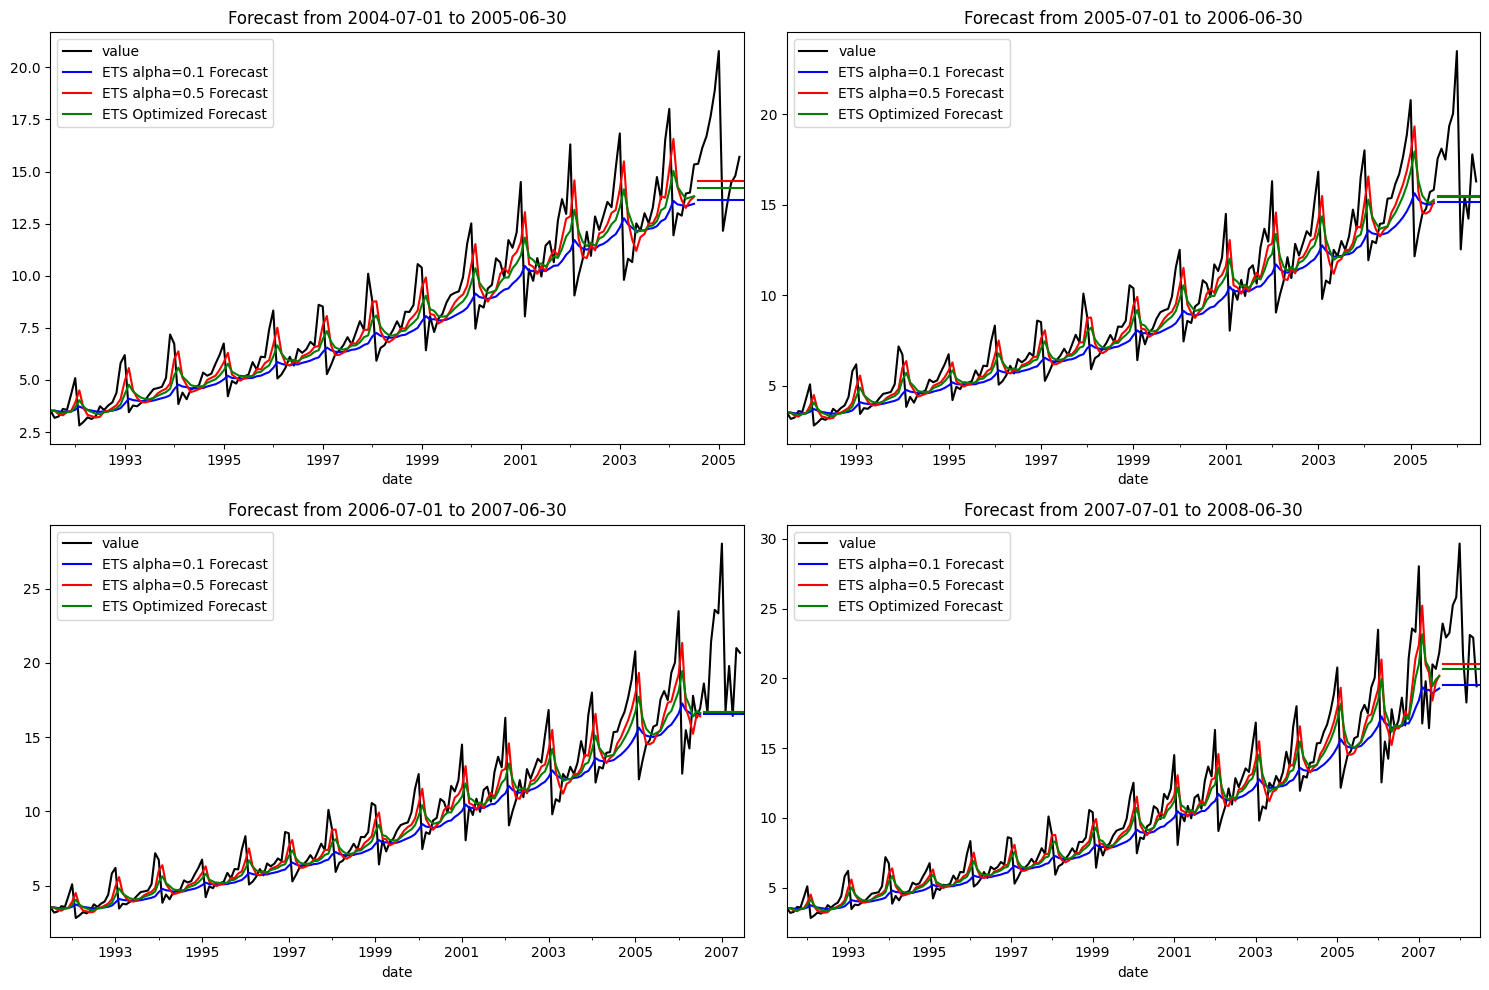

In [ ]:
# Create a single exponential smoothing model
def init_single_ets(df_train: pd.DataFrame, test_size: int, smoothing_level, optimized: bool):
  ins = SimpleExpSmoothing(df_train).fit(smoothing_level=smoothing_level, optimized=optimized)
  ins_cast = ins.forecast(test_size).rename('alpha=%s'%ins.model.params['smoothing_level'])
  return (ins, ins_cast)

def plot_est(ins, ins_cast, color: str, label: str, key_name: str):
  # Plot forecasts and fitted values
  ins_cast.plot(ax=ax, color=color, legend=True, label=label)
  ins.fittedvalues.plot(ax=ax, color=color)


# Initialize a dictionary to store forecasting results from different models in different test period
forecasts = {}
# Create a figure and an array of axes with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the array of axes for easier iteration
# Plot simple expoential smoothing model forecasting values against test data
for i, (start, end) in enumerate(backtest_periods):
  # Split the train data and test data
  train_data = df_sales[:start]
  test_size = len(df_sales[start:end])
  # Fit multiple single exponential smoothing models
  ins1, forecasts[(start, end,  model_names[0])] = init_single_ets(train_data, test_size, 0.1, False)
  ins2, forecasts[(start, end, model_names[1])] = init_single_ets(train_data, test_size, 0.5, False)
  ins3, forecasts[(start, end, model_names[2])] = init_single_ets(train_data, test_size, None, True)
  # Plot the models above for forecasting values against real values
  ax = axes[i]
  # Plot actual sales data
  df_sales[:end].plot(ax=ax, color='black', legend=True, label='Actual Sales')
  # Plot forecasts and fitted values
  plot_est(ins1, forecasts[(start, end, model_names[0])], 'blue', 'ETS alpha=0.1 Forecast', model_names[0])
  plot_est(ins2, forecasts[(start, end, model_names[1])], 'red', 'ETS alpha=0.5 Forecast', model_names[1])
  plot_est(ins3, forecasts[(start, end, model_names[2])], 'green', 'ETS Optimized Forecast', model_names[2])
  # Set the title for each subplot to the corresponding period
  ax.set_title(f'Forecast from {start.date()} to {end.date()}')
  ax.legend()
# Improve the layout
plt.tight_layout()
# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


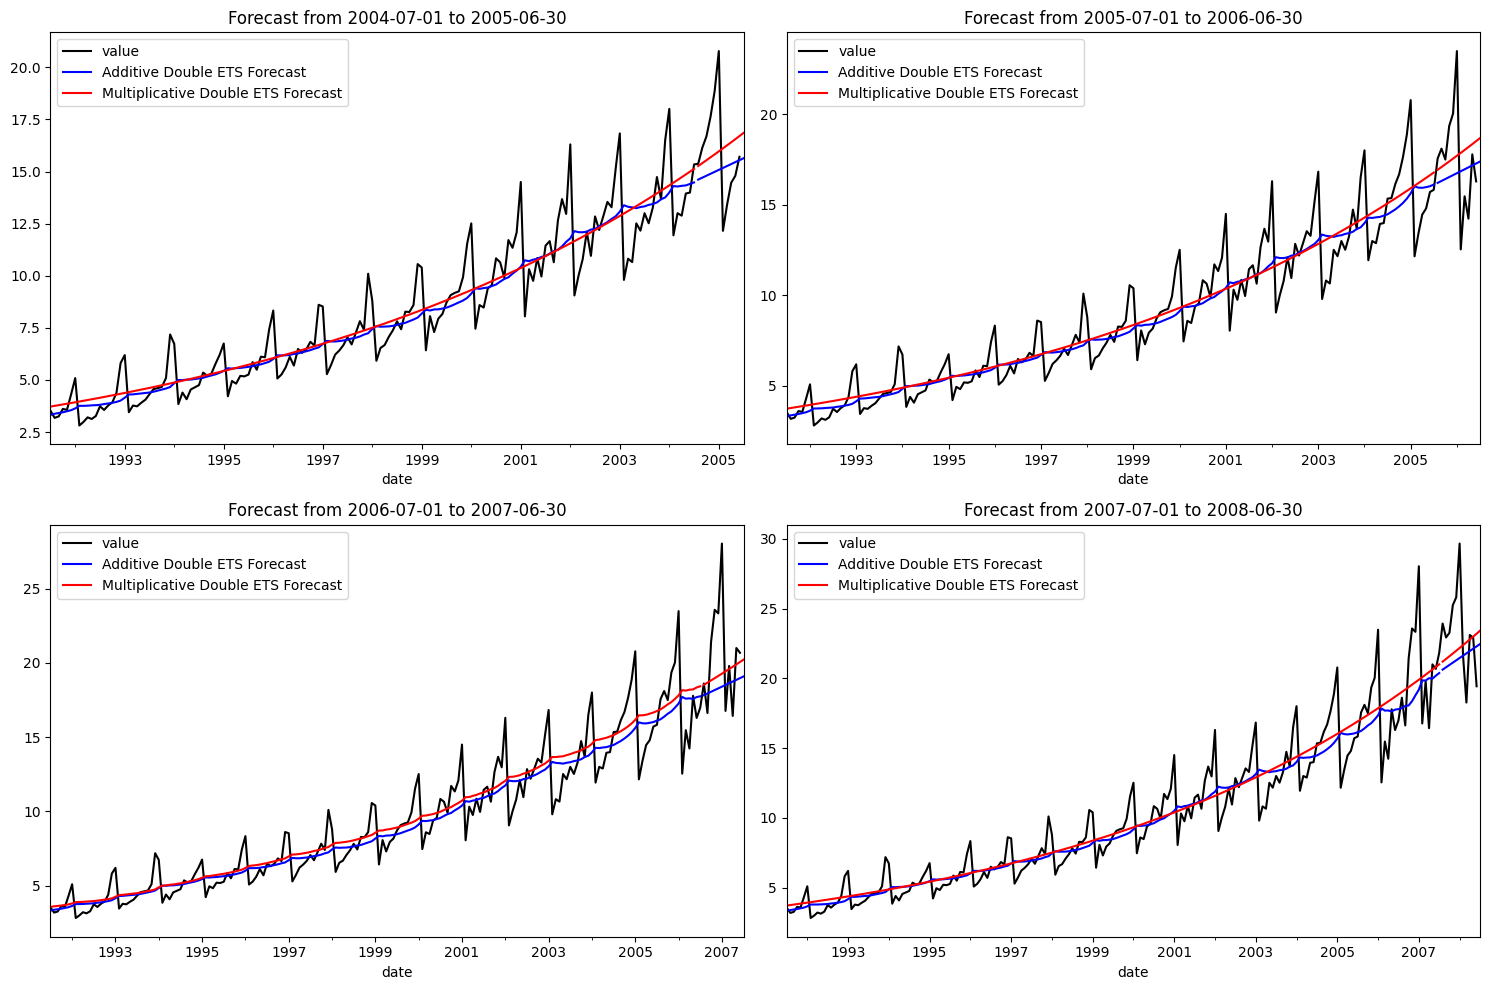

In [ ]:
def init_double_ets(train_data: pd.DataFrame, test_size: int, trend: str):
  double_ets = ExponentialSmoothing(train_data, trend=trend).fit()
  double_ets_pred = double_ets.forecast(test_size)
  return (double_ets, double_ets_pred)

# Create a figure and an array of axes with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the array of axes for easier iteration
# Plot double expoential smoothing model forecasting values against test data
for i, (start, end) in enumerate(backtest_periods):
  # Split the train data and test data
  train_data = df_sales[:start]
  test_size = len(df_sales[start:end])
  # Fit multiple double exponential smoothing models
  double_ets1, forecasts[(start, end, model_names[3])] = init_double_ets(train_data, test_size, 'add')
  double_ets2, forecasts[(start, end, model_names[4])] = init_double_ets(train_data, test_size, 'mul')
  # Plot the models above for forecasting values against real values
  ax = axes[i]
  # Plot actual sales data
  df_sales[:end].plot(ax=ax, color='black', legend=True, label='Actual Sales')
  # Plot forecasts and fitted values
  plot_est(double_ets1, forecasts[(start, end, model_names[3])], 'blue', 'Additive Double ETS Forecast', model_names[3])
  plot_est(double_ets2, forecasts[(start, end, model_names[4])], 'red', 'Multiplicative Double ETS Forecast', model_names[4])
  # Set the title for each subplot to the corresponding period
  ax.set_title(f'Forecast from {start.date()} to {end.date()}')
  ax.legend()
# Improve the layout
plt.tight_layout()
# Show the plot
plt.show()

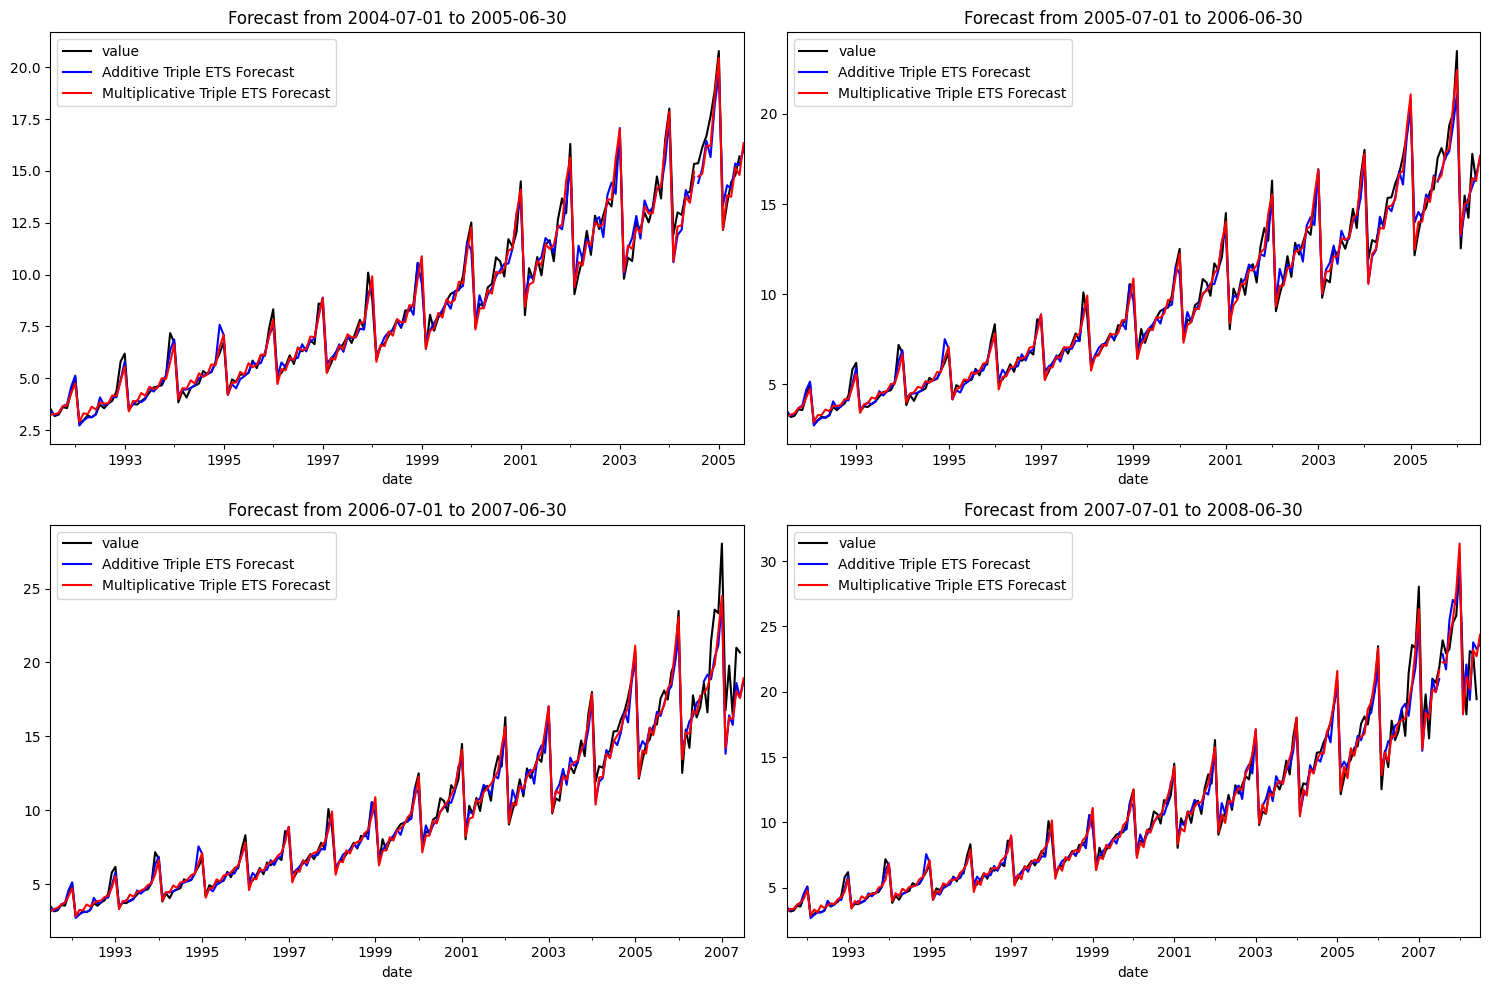

In [ ]:
def init_triple_ets(train_data: pd.DataFrame, test_size: int, trend: str, seasonal: str, seasonal_periods: int=12):
  #Plot for triple ETS additive
  triple_ets = ExponentialSmoothing(train_data, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
  triple_ets_pred = triple_ets.forecast(test_size)
  return (triple_ets, triple_ets_pred)

# Create a figure and an array of axes with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the array of axes for easier iteration
# Plot double expoential smoothing model forecasting values against test data
for i, (start, end) in enumerate(backtest_periods):
  # Split the train data and test data
  train_data = df_sales[:start]
  test_size = len(df_sales[start:end])
  # Fit multiple double exponential smoothing models
  triple_ets1, forecasts[(start, end, model_names[5])] = init_triple_ets(train_data, test_size, 'add', 'add')
  triple_ets2, forecasts[(start, end, model_names[6])] = init_triple_ets(train_data, test_size, 'add', 'mul')
  # Plot the models above for forecasting values against real values
  ax = axes[i]
  # Plot actual sales data
  df_sales[:end].plot(ax=ax, color='black', legend=True, label='Actual Sales')
  # Plot forecasts and fitted values
  plot_est(triple_ets1, forecasts[(start, end, model_names[5])], 'blue', 'Additive Triple ETS Forecast', model_names[5])
  plot_est(triple_ets2, forecasts[(start, end, model_names[6])], 'red', 'Multiplicative Triple ETS Forecast', model_names[6])
  # Set the title for each subplot to the corresponding period
  ax.set_title(f'Forecast from {start.date()} to {end.date()}')
  ax.legend()
# Improve the layout
plt.tight_layout()
# Show the plot
plt.show()

# Part 2: ARIMA Models

In [ ]:
def adf_test(df: pd.DataFrame):
  X = df.values
  result = adfuller(X)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

def arrange_acf_plot(df: pd.DataFrame):
  # Plot autocorrelation
  fig = plot_acf(df, lags=100)
  fig.set_size_inches((10, 5))
  # Tight layout to realign things
  fig.tight_layout()
  plt.show()

# Check whether the time series data is stationary
adf_test(df_sales)

ADF Statistic: 3.145186
p-value: 1.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


Since the ADF statistic is greater than the 5% confidence interval critical value and the p value is greater than 0.05, we fail to reject the null hypothesis and we assume that it is non-stationary. Next we need to difference the data to make it stationary so that we can use it to create ARIMA models.

ADF Statistic: -2.092723
p-value: 0.247451
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


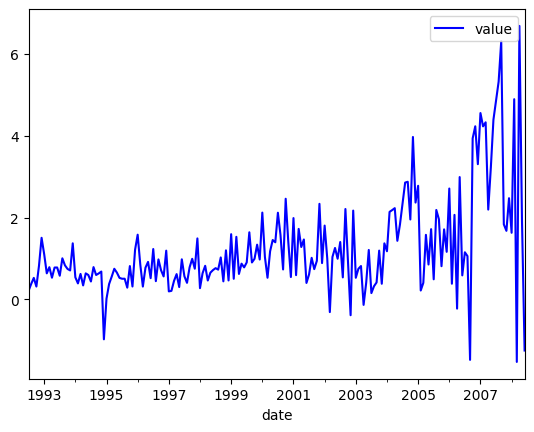

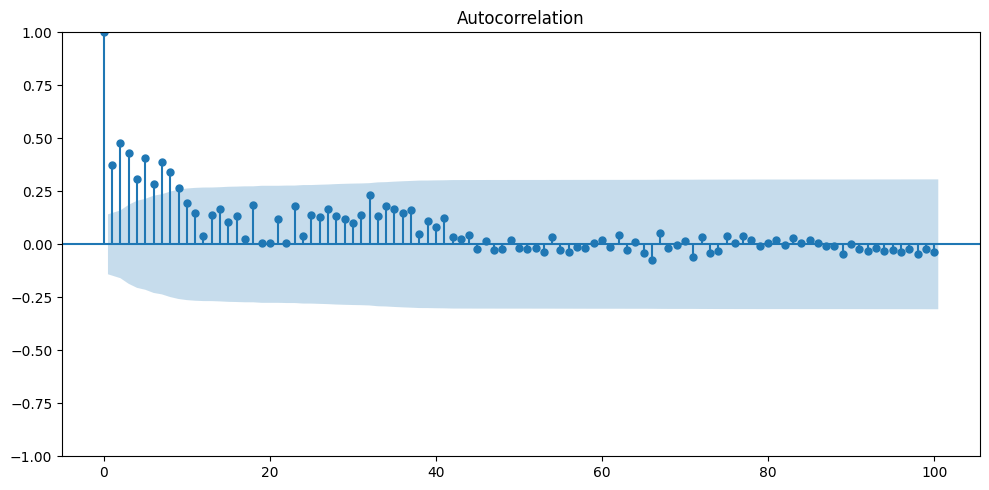

In [ ]:
# Difference the seasonality of the data first
seasnl_diff_df = df_sales.diff(12).dropna()
# Do a adf test to check stationarity
adf_test(seasnl_diff_df)
# Plot the differenced dataset
seasnl_diff_df.plot(color='blue')
# Plot autocorrelation
arrange_acf_plot(seasnl_diff_df)


After differencing the dataset by seasonality, we do see that seasonality disappears on the plot, but there still seems to be a trend here. By inspecting the ADF statistics we find that the differenced dataset is still non-stationary because we fail to reject the null hypothesis (p value > 0.05), then we need to difference the data again to make it stationary.

ADF Statistic: -4.783440
p-value: 0.000058
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


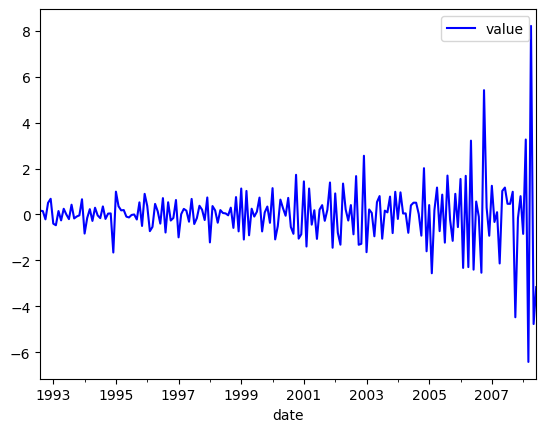

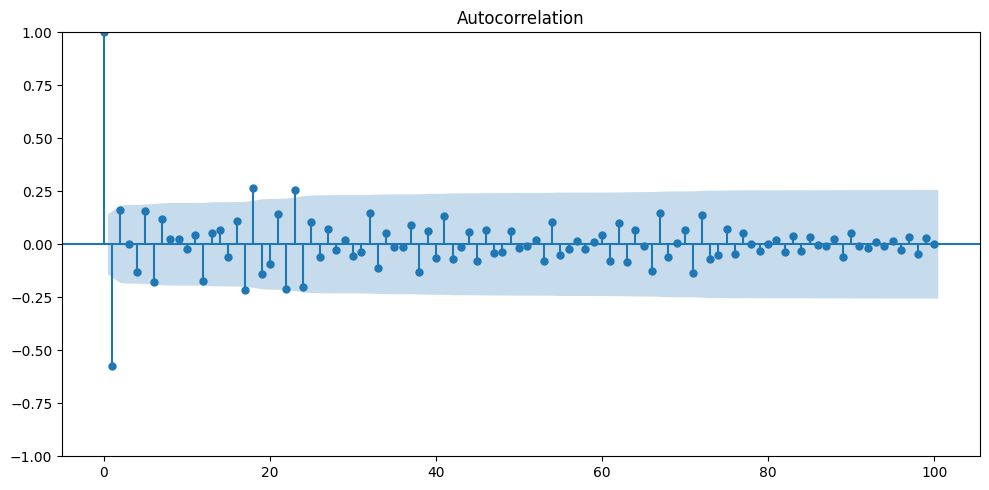

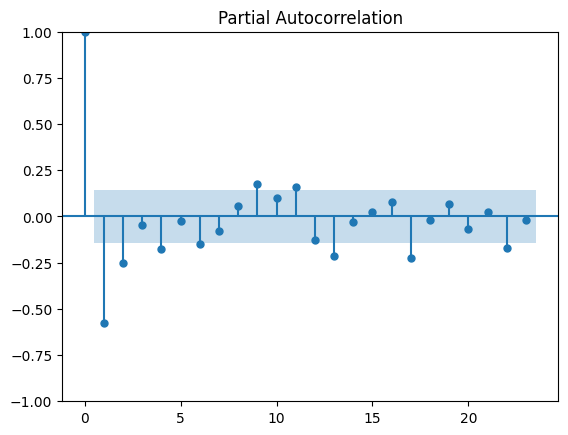

In [ ]:
# Difference the dataset again to remove trend
second_diff_df = seasnl_diff_df.diff().dropna()
# Do a adf test to check stationarity
adf_test(second_diff_df)
# Plot the differenced dataset
second_diff_df.plot(color='blue')
# Plot autocorrelation
arrange_acf_plot(second_diff_df)
# Plot PACF of the differenced time series.
plot_pacf(second_diff_df)
plt.show()

After differencing the data again we successfully remove the trend. Since the p value of adf test is less than 0.05, we have enought evidence to reject the null hypothesis and conclude that the second differenced data is now stationary. Then we can fit ARIMA models and see how they perform under differeny backtest time periods.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=595.013, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=578.719, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=545.986, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=593.358, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=536.971, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=538.660, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=538.770, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=537.138, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=572.634, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=525.223, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=539.547, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 se

<ipython-input-88-580f54590932>:50: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecasts[(start, end, model_names[8])] = pd.Series(fc_auto_unseasonal, index=test_data.index).fillna(method='bfill')
<ipython-input-88-580f54590932>:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecasts[(start, end, model_names[9])] = pd.Series(fc_auto_seasonal, index=test_data.index).fillna(method='bfill')


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=644.377, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=615.849, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=658.427, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=602.402, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=604.135, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=604.214, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=603.038, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=638.074, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=593.944, Time=0.65 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=601.008, Time=0.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=587.899, Time=0.78 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=595.380, Time=0.67 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=592.729, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=602.378, Time=0.39 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 5.227 seconds
Performing st

<ipython-input-88-580f54590932>:50: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecasts[(start, end, model_names[8])] = pd.Series(fc_auto_unseasonal, index=test_data.index).fillna(method='bfill')
<ipython-input-88-580f54590932>:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecasts[(start, end, model_names[9])] = pd.Series(fc_auto_seasonal, index=test_data.index).fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=746.844, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=723.779, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=693.421, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=745.120, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=681.759, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=683.747, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=683.753, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=683.525, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=720.757, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=674.511, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=675.109, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=675.156, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=684.136, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=682.771, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=658.032, Time=0.94 sec
 ARIMA(3,1,3)(0,0,0)[0]  

<ipython-input-88-580f54590932>:50: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecasts[(start, end, model_names[8])] = pd.Series(fc_auto_unseasonal, index=test_data.index).fillna(method='bfill')
<ipython-input-88-580f54590932>:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecasts[(start, end, model_names[9])] = pd.Series(fc_auto_seasonal, index=test_data.index).fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=840.962, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=809.031, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=787.242, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=839.343, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=774.957, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=775.729, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=776.441, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=778.325, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=809.341, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=765.367, Time=0.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=753.105, Time=0.78 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=771.438, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.60 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] 

<ipython-input-88-580f54590932>:50: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecasts[(start, end, model_names[8])] = pd.Series(fc_auto_unseasonal, index=test_data.index).fillna(method='bfill')
<ipython-input-88-580f54590932>:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecasts[(start, end, model_names[9])] = pd.Series(fc_auto_seasonal, index=test_data.index).fillna(method='bfill')


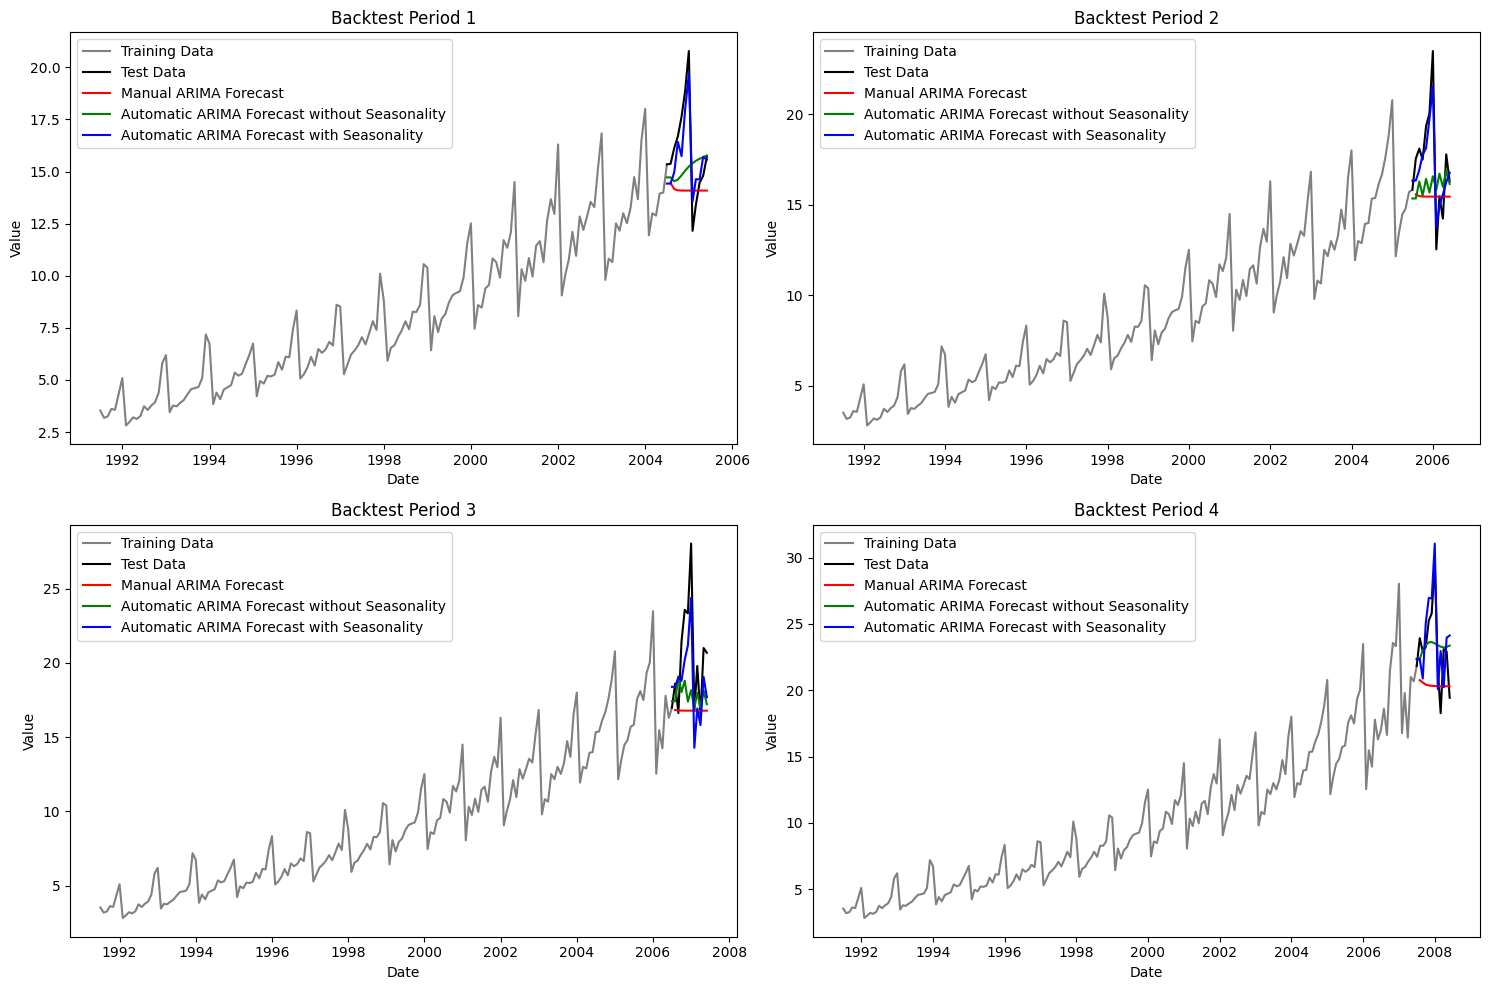

In [ ]:
def init_manual_arima(df_train: pd.DataFrame, order: tuple):
    # Create the ARIMA model manually
    arima_manual_model = sm.tsa.ARIMA(df_train, order=order)
    manual_model_fit = arima_manual_model.fit()
    return (arima_manual_model, manual_model_fit)

def plot_arima_model(test_data, forecast_values, ax, color, label):
    # Create pandas Series for forecasts and intervals
    fc_series = pd.Series(forecast_values, index=test_data.index)
    # Plot using Matplotlib directly
    ax.plot(fc_series.index, fc_series.values, color=color, label=label)

# Create a figure and an array of axes with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the array of axes for easier iteration

for i, (start, end) in enumerate(backtest_periods):
    # Split the train data and test data
    train_data = df_sales[:start]
    test_data = df_sales[start:end].copy()
    # Create a manual ARIMA model
    arima_manual, arima_manual_fit = init_manual_arima(train_data, (2, 1, 1))
    # Create an automatic ARIMA model without seasonality
    arima_auto_non_seasonal = pm.auto_arima(train_data, start_p=0, start_q=0,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=1,              # frequency of series
                          d=1,           # Set d to 1 since we know it requires first order differencing
                          seasonal=False,   # No Seasonality
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
    # Create an automatic ARIMA model with seasonality
    arima_auto_seasonal = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
    print(f'Length of test data: {len(test_data)}')
    # Forecast the next 12 values
    forecasts[(start, end, model_names[7])] = arima_manual_fit.forecast(steps=len(test_data))
    fc_auto_unseasonal = arima_auto_non_seasonal.predict(n_periods=len(test_data))
    fc_auto_seasonal = arima_auto_seasonal.predict(n_periods=len(test_data))
    print(fc_auto_unseasonal)
    print(fc_auto_seasonal)
    forecasts[(start, end, model_names[8])] = pd.Series(fc_auto_unseasonal, index=test_data.index).fillna(method='bfill')
    forecasts[(start, end, model_names[9])] = pd.Series(fc_auto_seasonal, index=test_data.index).fillna(method='bfill')
    # Plot the manual ARIMA model
    ax = axes[i]
    # Plot training data
    ax.plot(train_data.index, train_data.values, color='grey', label='Training Data')
    # Plot test data
    ax.plot(test_data.index, test_data.values, color='black', label='Test Data')
    # Plot forecasts of all ARIMA models for comparison
    plot_arima_model(test_data, forecasts[(start, end, model_names[7])], ax, 'red', 'Manual ARIMA Forecast')
    plot_arima_model(test_data, forecasts[(start, end, model_names[8])], ax, 'green', 'Automatic ARIMA Forecast without Seasonality')
    plot_arima_model(test_data, forecasts[(start, end, model_names[9])], ax, 'blue', 'Automatic ARIMA Forecast with Seasonality')
    # Add title and labels if desired
    ax.set_title(f'Backtest Period {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    # Set the legend
    ax.legend()

# Improve the layout
plt.tight_layout()
# Show the plot
plt.show()




In [ ]:
def metrics_cal(actuals, predictions, model):
  mse = mean_squared_error(actuals, predictions)
  rmse = sqrt(mse)
  mae = mean_absolute_error(actuals, predictions)
  mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
  wape = np.sum(np.abs(actuals - predictions)) / np.sum(np.abs(actuals))
  denominator = (np.abs(actuals)+np.abs(predictions))/2.0
  smape = 2 * np.mean(np.abs(predictions - actuals) / denominator) * 100
  df = pd.DataFrame({
      'Model': [model],
      'RMSE': [rmse],
      'MAE': [mae],
      'MAPE': [mape],
      'WAPE': [wape],
      'SMAPE': [smape]
  })
  return df

# Dictionary to store metrics DataFrames for each backtest period
# Note that ChatGPT is used in this loop
dict_metrics_df = {}
# Get the test data for each backtest time period
for i, (start, end) in enumerate(backtest_periods):
  # Initialize an empty DataFrame for metrics in this iteration
  metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE', 'WAPE', 'SMAPE'])
  # Split the train data and test data
  test_data = df_sales[start:end].copy()
  actuals = test_data.values.flatten()
  # Collect metrics for each model
  for idx, model_name in enumerate(model_names):
      predictions = forecasts[(start, end, model_name)].values.flatten()
      df_metrics = metrics_cal(actuals, predictions, model_names[idx])
      metrics_dataframe = pd.concat([metrics_dataframe, df_metrics], ignore_index=True)
  # Compute the average of the metrics (excluding the 'Model' column)
  avg_metrics = metrics_dataframe[['RMSE', 'MAE', 'MAPE', 'WAPE', 'SMAPE']].mean()
  # Create a new DataFrame row with 'Model' = 'Average' and the computed averages
  avg_row = pd.DataFrame({
      'Model': ['Average'],
      'RMSE': [avg_metrics['RMSE']],
      'MAE': [avg_metrics['MAE']],
      'MAPE': [avg_metrics['MAPE']],
      'WAPE': [avg_metrics['WAPE']],
      'SMAPE': [avg_metrics['SMAPE']]
  })
  # Append the average row to the metrics_dataframe
  metrics_dataframe = pd.concat([metrics_dataframe, avg_row], ignore_index=True)
  # Sort the DataFrame by a metric (if desired)
  metrics_dataframe = metrics_dataframe.sort_values(by='MAE')
  # Store the DataFrame for this iteration
  dict_metrics_df[i] = metrics_dataframe
  # Display the DataFrame
  print(f"\nMetrics for Backtest Period {i+1}:")
  print(metrics_dataframe)

In [ ]:
# Calculate the average model performance across all backtesting time periods
# Iterate through the dictionary of dataframes to concatenate them into one dataframe
average_df = pd.concat([dict_metrics_df[i] for i in range(len(backtest_periods))])
# Group by the Model column and calculate the average value
average_df = average_df.groupby('Model').mean()
# Sort the dataframe by MAE
df_est_metrics = average_df.sort_values(by='MAE')
# Display the average dataframe
print(df_est_metrics)

                            RMSE       MAE       MAPE      WAPE      SMAPE
Model                                                                     
Auto ARIMA Seasonal     1.761984  1.553629   8.002305  0.078517  16.095484
Triple ETS 1            3.481172  2.156676  10.215985  0.110012  22.013771
Triple ETS 2            3.606804  2.196916  10.400893  0.112799  22.430416
Double ETS 2            3.012415  2.337982  12.351651  0.122785  24.425147
Auto ARIMA NonSeasonal  3.081843  2.355766  11.971530  0.124916  25.036807
Double ETS 1            3.157018  2.481252  12.490165  0.129421  25.954725
Average                 3.327198  2.489582  12.219527  0.129316  26.137617
Single ETS 2            3.603268  2.765869  13.324751  0.143977  29.188829
Single ETS 3            3.717632  2.888370  13.909665  0.150544  30.631729
ARIMA Manual            3.765378  2.919104  14.007676  0.151858  30.917846
Single ETS 1            4.084469  3.240260  15.520653  0.168327  34.681412


After calculating multiple performance metrics for each of the models that we created and integarting the results from four backtesting time periods into one dataframe by taking the avergae, we can see that the automatic ARIMA model with seasonality considered performs the best across all metrics (note that the metrics dataframe above is sorted by column MAE). This result is not surprising because:


1. When we plot every model's forecast values against the orignal sales data, we can see that automatic ARIMA model with seasonality is the closest line to test data whrease others are somewhat off, which is visually clear to see. Besides, when we did exploratory data analytics on the orignal sales data, we found that it has an additive trend (data generally goes up with time) and multiplicative seasonality (the variance of each season become larger). This data characteristic is also verified by looking at the decomposition plot. Since it is not stationary, we tried differencing the data twice: first by seasonality and then by trend. After that we confirmed that the new dataset is stationary by using adf test. Therefore, we configured the automatic ARIMA model with seasonality based on the findings above.
2. Compared to triple ETS 1 (triple ETS with additive trend and additive seasonality), ARIMA models include seasonal terms that can capture complex seasonal patterns effectively. Note that automatic ARIMA model without seasonal term performs even wrose than double ets 2, which means the automatic ARIMA model with seasonality really captures some complex seasonality information of the data that ETS models cannot capture.

Therefore, I would choose automatic ARIMA model with seasonality to predict the values of next 12 month.

